In [2]:
import os
import glob
import random
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from tqdm import tqdm
import seaborn as sns

# Grafikler için stil ayarı
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- AYARLAR ---
# Notebook'un 'notebooks/' klasöründe olduğunu varsayıyoruz
BASE_DIR = Path("../data/processed/train")
IMG_DIR = BASE_DIR / "images"
LABEL_DIR = BASE_DIR / "labels"

# Sınıf Haritası (make_dataset.py ile aynı olmalı)
CLASS_NAMES = {
    0: 'Impacted (Gömülü)',
    1: 'Caries (Çürük)',
    2: 'Periapical Lesion (Lezyon)',
    3: 'Deep Caries (Derin Çürük)'
}

print(f"Resim Dizini: {IMG_DIR}")
print(f"Etiket Dizini: {LABEL_DIR}")

Resim Dizini: ../data/processed/train/images
Etiket Dizini: ../data/processed/train/labels


In [ ]:
# Tüm txt dosyalarını bul
label_files = list(LABEL_DIR.glob("*.txt"))
print(f"Toplam Etiket Dosyası Sayısı: {len(label_files)}")

# Verileri topla
data = []
for file_path in tqdm(label_files, desc="Dosyalar okunuyor"):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            
            data.append({
                'filename': file_path.stem, # dosya adı (uzantısız)
                'class_id': class_id,
                'class_name': CLASS_NAMES.get(class_id, 'Unknown'),
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })

# DataFrame'e çevir
df = pd.DataFrame(data)
print(f"\nToplam Nesne (Bbox) Sayısı: {len(df)}")
if not df.empty:
    print(df.head())
else:
    print("❌ HATA: Hiçbir etiket okunamadı! Klasör boş mu?")

Toplam Etiket Dosyası Sayısı: 678


Dosyalar okunuyor: 100%|██████████| 678/678 [00:00<00:00, 6915.76it/s]


Toplam Nesne (Bbox) Sayısı: 3529
    filename  class_id         class_name  x_center  y_center     width  \
0  train_702         1     Caries (Çürük)  0.305393  0.474105  0.076230   
1  train_702         1     Caries (Çürük)  0.339255  0.593490  0.073710   
2   train_54         0  Impacted (Gömülü)  0.254477  0.522749  0.061983   
3   train_54         1     Caries (Çürük)  0.341770  0.560111  0.082300   
4   train_54         1     Caries (Çürük)  0.380510  0.578017  0.060606   

     height  
0  0.119700  
1  0.112770  
2  0.081267  
3  0.091942  
4  0.102273  



--- SINIF DAĞILIMI (Sayılar) ---
class_name
Caries (Çürük)                2189
Impacted (Gömülü)              604
Deep Caries (Derin Çürük)      578
Periapical Lesion (Lezyon)     158
Name: count, dtype: int64


/var/folders/l_/vxjww1y12_z_dh9ph30zv2dh0000gn/T/ipykernel_98886/1936961745.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


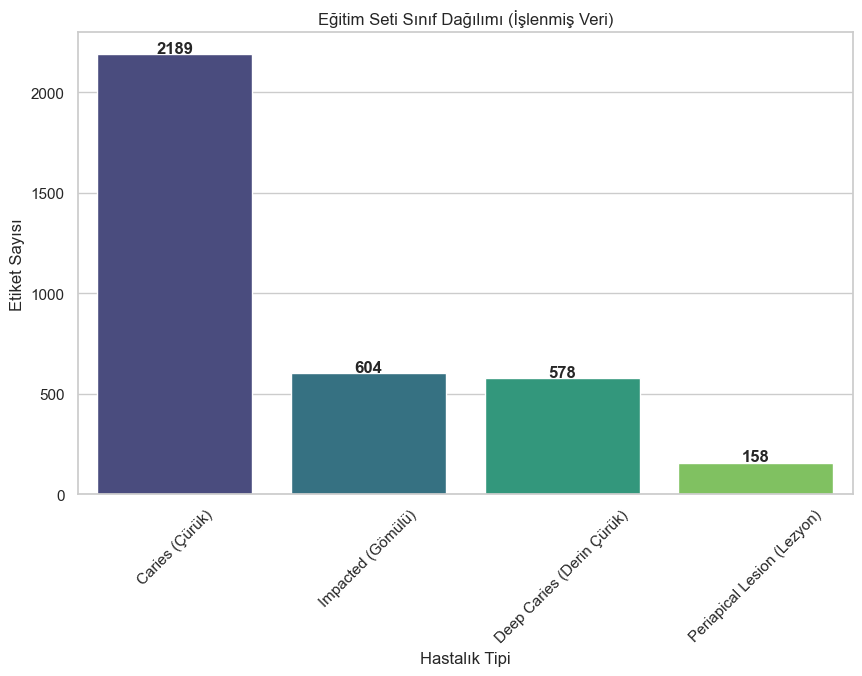

In [4]:
if not df.empty:
    # Sayım yap
    class_counts = df['class_name'].value_counts()
    print("\n--- SINIF DAĞILIMI (Sayılar) ---")
    print(class_counts)

    # Görselleştir
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title("Eğitim Seti Sınıf Dağılımı (İşlenmiş Veri)")
    plt.xlabel("Hastalık Tipi")
    plt.ylabel("Etiket Sayısı")
    plt.xticks(rotation=45)
    
    # Barların üzerine sayıları yaz
    for i, v in enumerate(class_counts.values):
        plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
        
    plt.show()
else:
    print("Veri yok, grafik çizilemedi.")

Dosya: train_442


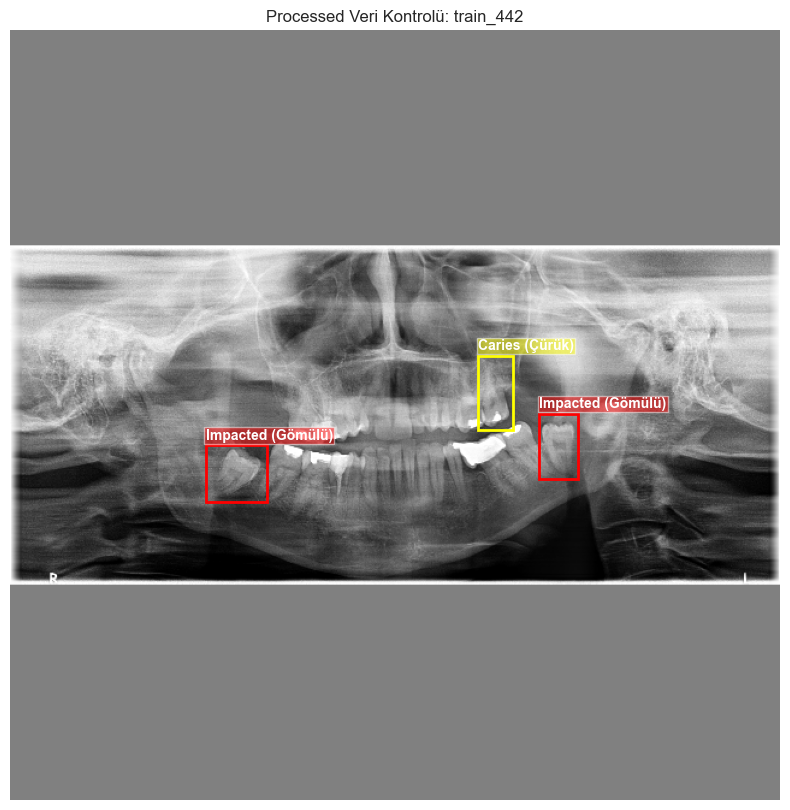

Dosya: train_612


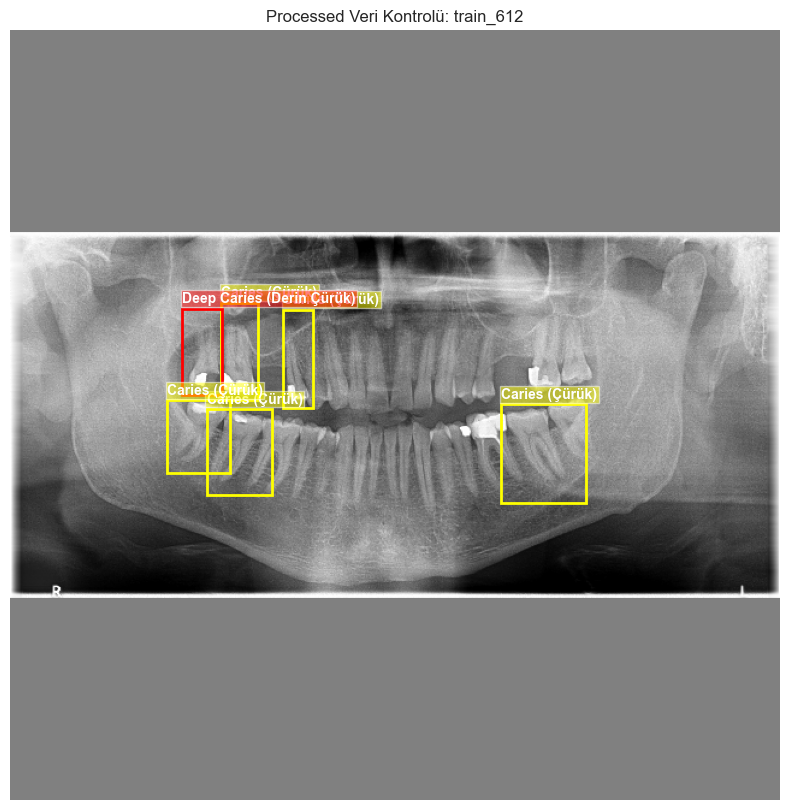

Dosya: train_19


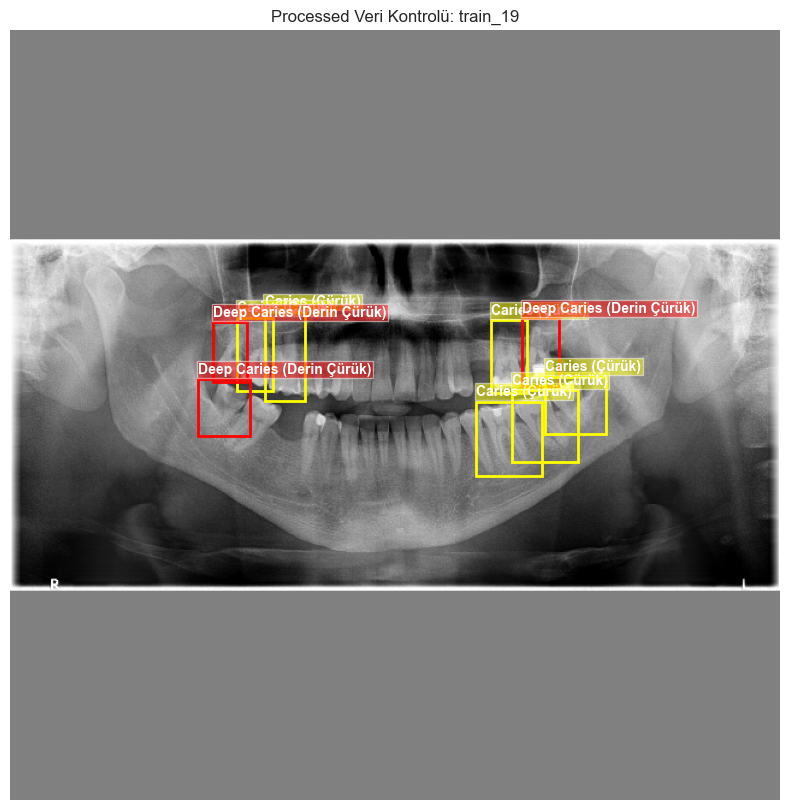

In [5]:
def visualize_yolo_sample():
    # Rastgele bir etiket dosyası seç
    if not label_files:
        print("Dosya yok!")
        return

    random_label_file = random.choice(label_files)
    file_id = random_label_file.stem
    
    # İlgili resmi bul
    img_path = IMG_DIR / (file_id + ".png") # make_dataset.py png kaydetmişti, jpg ise değiştir
    if not img_path.exists():
        # Belki jpg'dir?
        img_path = IMG_DIR / (file_id + ".jpg")
    
    if not img_path.exists():
        print(f"Resim bulunamadı: {file_id}")
        return

    # Resmi yükle
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Matplotlib için RGB
    h, w, _ = image.shape

    # Etiketleri oku
    with open(random_label_file, 'r') as f:
        labels = f.readlines()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    print(f"Dosya: {file_id}")
    
    for line in labels:
        parts = line.strip().split()
        class_id = int(parts[0])
        xc, yc, nw, nh = map(float, parts[1:])
        
        # YOLO (Normalize) -> Piksel Koordinatlarına Çevir
        # x_center, y_center, width, height -> x_min, y_min, w, h
        
        box_w = nw * w
        box_h = nh * h
        box_x = (xc * w) - (box_w / 2)
        box_y = (yc * h) - (box_h / 2)
        
        color = 'red'
        if class_id == 1: color = 'yellow' # Caries
        elif class_id == 2: color = 'cyan' # Lezyon
        
        # Kutuyu Çiz
        rect = patches.Rectangle(
            (box_x, box_y), box_w, box_h, 
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # Yazı
        plt.text(
            box_x, box_y - 5, CLASS_NAMES.get(class_id, str(class_id)), 
            color='white', fontsize=10, weight='bold',
            bbox=dict(facecolor=color, alpha=0.5, pad=1)
        )
        
    plt.axis('off')
    plt.title(f"Processed Veri Kontrolü: {file_id}")
    plt.show()

# 3-4 farklı örnek görmek için birkaç kez çalıştır
for _ in range(3):
    visualize_yolo_sample()

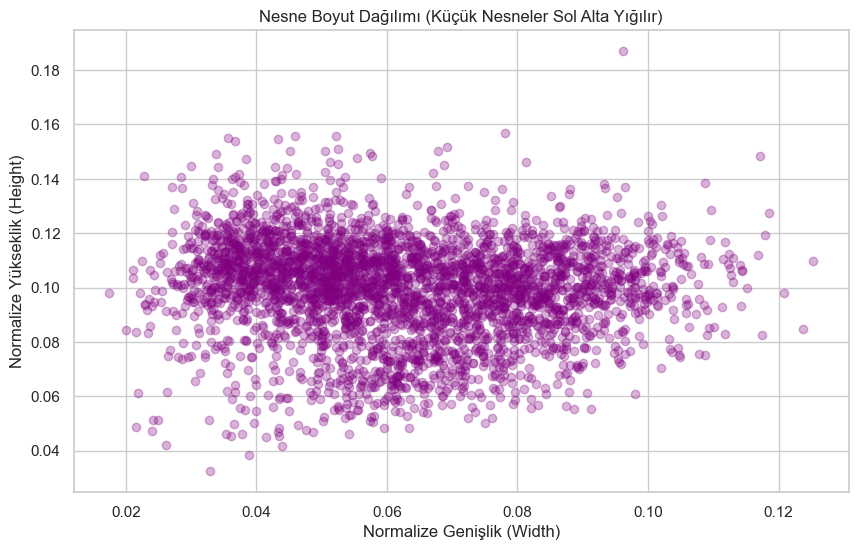

Ortalama Genişlik: 0.06227054151317654
Ortalama Yükseklik: 0.09960672711816378


In [6]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    # Genişlik ve Yükseklik dağılımı (Normalize edilmiş 0-1 arası)
    plt.scatter(df['width'], df['height'], alpha=0.3, color='purple')
    plt.xlabel("Normalize Genişlik (Width)")
    plt.ylabel("Normalize Yükseklik (Height)")
    plt.title("Nesne Boyut Dağılımı (Küçük Nesneler Sol Alta Yığılır)")
    plt.grid(True)
    plt.show()
    
    print("Ortalama Genişlik:", df['width'].mean())
    print("Ortalama Yükseklik:", df['height'].mean())

JSON yükleniyor: ../data/raw/DENTEX/train/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json ...
Hastalık Sınıfları: {0: 'Impacted', 1: 'Caries', 2: 'Periapical Lesion', 3: 'Deep Caries'}

--- train_19.png ---
Orijinal Boyut: 2881x1316
Etiket: Caries | Kutu: [950.090909090909, 269.45454545454544, 150.909090909091, 334.54545454545445]
Etiket: Caries | Kutu: [848.3636363636363, 291.72727272727263, 132.72727272727275, 272.27272727272737]
Etiket: Deep Caries | Kutu: [759.0, 307.81818181818176, 124.45454545454538, 223.63636363636363]
Etiket: Caries | Kutu: [1797.6363636363635, 300.5454545454545, 134.5454545454545, 270.9090909090909]
Etiket: Deep Caries | Kutu: [1913.7272727272725, 292.9090909090909, 138.27272727272748, 252.72727272727275]
Etiket: Caries | Kutu: [1741.090909090909, 604.8181818181818, 245.45454545454527, 278.18181818181824]
Etiket: Caries | Kutu: [1875.6363636363635, 562.9999999999999, 247.27272727272702, 267.27272727272737]
Etiket: Caries | Ku

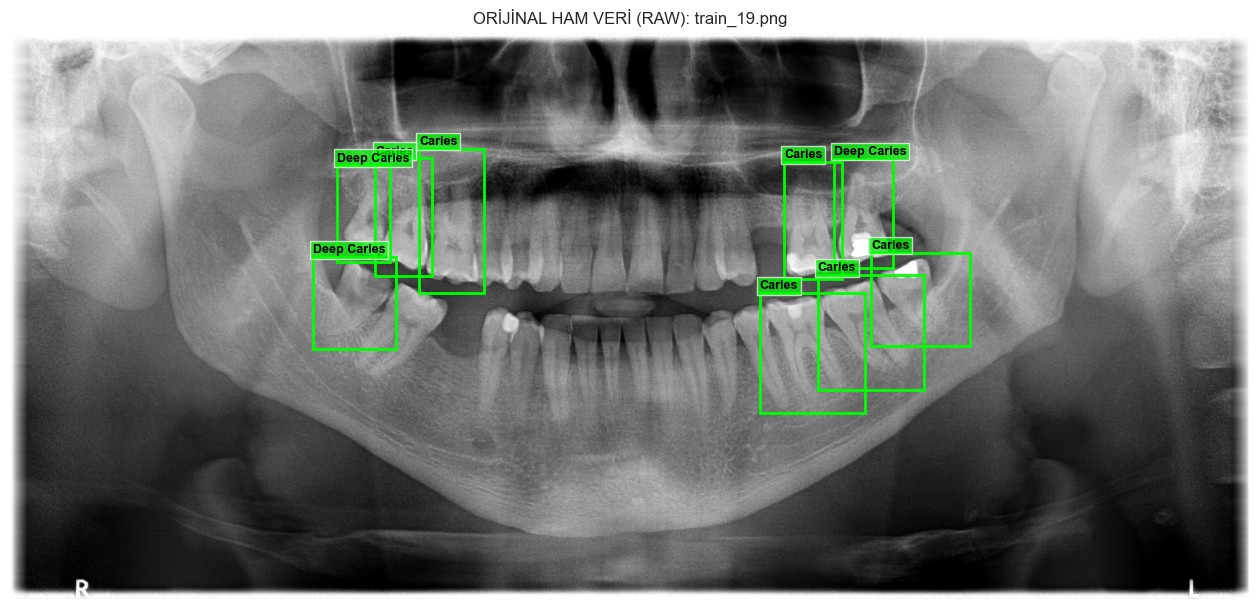


--- train_612.png ---
Orijinal Boyut: 2769x1316
Etiket: Caries | Kutu: [981.0, 276.40350877192975, 108.0, 354.38596491228066]
Etiket: Caries | Kutu: [757.1754385964912, 251.84210526315786, 131.57894736842104, 349.12280701754383]
Etiket: Deep Caries | Kutu: [616.0, 272.8947368421052, 145.0, 311.1052631578948]
Etiket: Caries | Kutu: [1764.19298245614, 617.0, 303.50877192982466, 355.8947368421052]
Etiket: Caries | Kutu: [704.5438596491227, 634.298245614035, 235.0877192982456, 308.7719298245614]
Etiket: Caries | Kutu: [562.438596491228, 602.7192982456139, 228.07017543859638, 259.64912280701753]


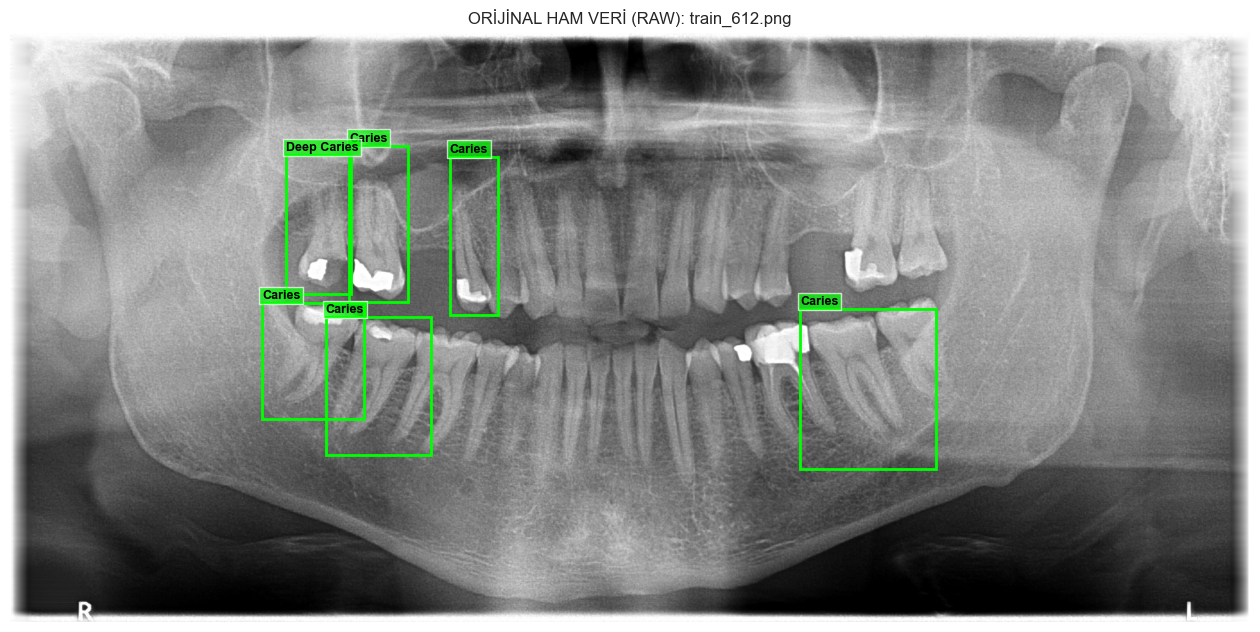

In [7]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

# --- 1. ORİJİNAL HAM VERİ YOLLARI ---
# Not: Bu yollar senin 'train' klasör yapına göredir.
BASE_RAW_DIR = Path("../data/raw/DENTEX/train/training_data/quadrant-enumeration-disease")
RAW_JSON = BASE_RAW_DIR / "train_quadrant_enumeration_disease.json"
RAW_IMG_DIR = BASE_RAW_DIR / "xrays"

# Kontrol edilecek dosyalar (png uzantısına dikkat)
TARGET_FILES = ["train_19.png", "train_612.png"]

# --- 2. JSON YÜKLEME ---
print(f"JSON yükleniyor: {RAW_JSON} ...")
with open(RAW_JSON, 'r') as f:
    raw_data = json.load(f)

# Kategori İsimleri (Hastalıklar)
cat_map_3 = {c['id']: c['name'] for c in raw_data['categories_3']}
print(f"Hastalık Sınıfları: {cat_map_3}")

# --- 3. ÇİZİM FONKSİYONU ---
def visualize_raw_original(target_filename):
    # Resim bilgisini bul
    img_info = next((img for img in raw_data['images'] if img['file_name'] == target_filename), None)
    
    if not img_info:
        print(f"❌ Resim JSON'da bulunamadı: {target_filename}")
        return

    img_id = img_info['id']
    img_path = RAW_IMG_DIR / target_filename
    
    if not img_path.exists():
        print(f"❌ Resim dosyası diskte yok: {img_path}")
        return

    # Resmi aç (Hiçbir resize işlemi yok!)
    image = Image.open(img_path)
    w, h = image.size
    print(f"\n--- {target_filename} ---")
    print(f"Orijinal Boyut: {w}x{h}")
    
    # Anotasyonları filtrele
    # Sadece Hastalık (Category 3) olanları alalım
    anns = [a for a in raw_data['annotations'] if a['image_id'] == img_id]
    
    plt.figure(figsize=(16, 10))
    plt.imshow(image, cmap='gray')
    ax = plt.gca()
    
    for ann in anns:
        # Sadece hastalık teşhisi olanları çizelim (category_id_3 verisi olanlar)
        diag_id = ann.get('category_id_3')
        
        if diag_id is not None:
            diag_name = cat_map_3.get(diag_id, 'Unknown')
            bbox = ann['bbox'] # [x, y, w, h] - Orijinal COCO formatı
            
            # Kutuyu Çiz (Yeşil: Orijinal Ham Veri)
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3], 
                linewidth=2, edgecolor='#00FF00', facecolor='none' # Parlak Yeşil
            )
            ax.add_patch(rect)
            
            # Etiket
            plt.text(
                bbox[0], bbox[1]-10, diag_name, 
                color='black', fontsize=9, fontweight='bold', 
                bbox=dict(facecolor='#00FF00', alpha=0.7, pad=2)
            )
            print(f"Etiket: {diag_name} | Kutu: {bbox}")

    plt.title(f"ORİJİNAL HAM VERİ (RAW): {target_filename}")
    plt.axis('off')
    plt.show()

# --- 4. ÇALIŞTIR ---
for f_name in TARGET_FILES:
    visualize_raw_original(f_name)